In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import curve_fit
from copy import deepcopy
import os
import pandas as pd
import seaborn as sns
sns.set(style='ticks')

In [2]:
prepath = '/home/emmanuel/archivos_paragrafficar_SERVICIOSOCIAL/Buffers_Datosyprogramas/Datos_todoslosPaises/'

In [3]:
def EvalnormCdf(x,mu,sigma):
    return scipy.stats.norm.cdf(np.log10(x),loc=mu,scale=sigma)

def ajuste(data_fit,funcion):
    X = data_fit[:,0]
    Y = data_fit[:,1]
    param_model, pcov1 = curve_fit(funcion,X,Y)
    return param_model

def get_parametros(country,level,ngrams,timeint,totalgrams):
    path = prepath+'{}/Level_{}/results_{}grams/{}hour_{}grams_RD.txt'.format(country,level,totalgrams,timeint,ngrams)
    data = np.loadtxt(path)
    parametros = ajuste(data,EvalnormCdf)
    return parametros

### LO DE ABAJO GUARDA LOS MU Y SIGMAS 

In [28]:
NGRAMS = [1,2,3,4,5]
TIME = [3,6,12,24,48,96]
countries = ["Mexico", "United_Kingdom","Spain","Argentina"]
totalgrams = 1000

pre = 'parametros_valores/'

for country in countries:
    # <--------------___!!!!!!!!
    #codigo auxiliar <--------------------Esto de abajo se tiene que modificar si aumentas paises 
    dist4country = { "Mexico":np.arange(0,11), "United_Kingdom":np.arange(0,10),"Spain":np.arange(0,9),"India":np.arange(0,11),'Argentina':np.arange(0,11)}
    base=2
    distancias = np.power(base, dist4country[country]).astype(float)*3*1000
    SPATIAL = dist4country[country]

    #ngrams variation
    
    #geographical scale fixed

    for level in SPATIAL:

        scheme = dict( zip( ['ti='+str(i) for i in TIME], [ [] for k in range(len(TIME)) ]) )
        muandsigma = {"mu":scheme, "sigma":deepcopy(scheme)}
        # <--------------___!!!!!!!!
        #Lo de abajo se debe aumentar acorde al numero de paises que se tengan entonces es el num de repeticiones en la lista de muandsigma
        Parametros_ti = dict([(count,elem) for count,elem in zip(countries,[muandsigma,muandsigma,muandsigma,muandsigma])])

        for timeint in TIME:
            for ngram in NGRAMS:
                try:
                    mu,sigma = get_parametros(country,level,ngram,timeint,totalgrams)
                except RuntimeError:
                    mu,sigma = np.nan,np.nan
                Parametros_ti[country]['mu']['ti={}'.format(timeint)].append(mu)
                Parametros_ti[country]['sigma']['ti={}'.format(timeint)].append(sigma)


        df_mu = pd.DataFrame(Parametros_ti[country]['mu'],index=NGRAMS)
        df_sigma = pd.DataFrame(Parametros_ti[country]['sigma'],index=NGRAMS)
        
        savingpathmu = os.path.join(pre,"{}ngrams".format(totalgrams),country,'display_ngrams','mu_vs_temporal')
        savingpathsigma = os.path.join(pre,'{}ngrams'.format(totalgrams),country,'display_ngrams','sigma_vs_temporal')
        
        if not os.path.exists(savingpathmu) or not os.path.exists(savingpathsigma):
            os.makedirs(savingpathmu)
            os.makedirs(savingpathsigma)
        df_mu.to_csv(os.path.join(savingpathmu,'{}Km'.format(distancias[level]/1000)))
        df_sigma.to_csv(os.path.join(savingpathsigma,'{}Km'.format(distancias[level]/1000)))
        
        
     # time interval fixed
    
    for timeint in TIME:
        tmpmu = dict( zip( dist4country[country], [[] for i in dist4country[country]] ) )
        tmpsigma = deepcopy(tmpmu)
        #MODIFICAR LO ABAJO SI AUEMNTO PAISES DEBO AGREGALOS A Parametros_sc  l<--------------___!!!!!!!!
        Parametros_sc = {"Mexico":{'mu':tmpmu ,'sigma':tmpsigma },  "United_Kingdom":{'mu':tmpmu ,'sigma':tmpsigma },'Spain':{'mu':tmpmu,'sigma':tmpsigma},'India':{'mu':tmpmu ,'sigma':tmpsigma },'Argentina':{'mu':tmpmu ,'sigma':tmpsigma}}
        for level in SPATIAL:
            for ngram in NGRAMS:
                try:
                    mu,sigma=get_parametros(country,level,ngram,timeint,totalgrams)
                except RuntimeError:
                    mu,sigma = np.nan,np.nan
                Parametros_sc[country]['mu'][level].append(mu)
                Parametros_sc[country]['sigma'][level].append(sigma)
            
        df_mu = pd.DataFrame({ str(distancia): Parametros_sc[country]["mu"][i] for(distancia,i) in zip( distancias,range(len(distancias))) },index=NGRAMS)
        df_sigma = pd.DataFrame({ str(distancia): Parametros_sc[country]["sigma"][i] for(distancia,i) in zip( distancias,range(len(distancias))) },index=NGRAMS)
        
        savingpathmu = os.path.join(pre,"{}ngrams".format(totalgrams),country,'display_ngrams','mu_vs_spatial')
        savingpathsigma = os.path.join(pre,'{}ngrams'.format(totalgrams),country,'display_ngrams','sigma_vs_spatial')
        
        if not os.path.exists(savingpathmu) or not os.path.exists(savingpathsigma):
            os.makedirs(savingpathmu)
            os.makedirs(savingpathsigma)
        df_mu.to_csv(os.path.join(savingpathmu,'{}hrs'.format(timeint)))
        df_sigma.to_csv(os.path.join(savingpathsigma,'{}hrs'.format(timeint)))
        

### Functions to plot and get data

In [4]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score

In [5]:
def mu_sigma_ngramsvar(vscale,value,country,level,ngrams,timeint,parametros,marker='o',ax=None):
    """
    Input:
    vscale: str, 'spatial' or 'time'
    value: str, 'mu' or 'sigma'
    Parametros expect a pandas dataframe object.
    """
    #codigo auxiliar de distancia 
    # MODIFICAR SI AGREGAS MAS PAISES  <--------------___!!!!!!!!
    dist4country = { "Mexico":np.arange(0,11), "United_Kingdom":np.arange(0,10),"Spain":np.arange(0,9),"India":np.arange(0,11),'Argentina':np.arange(0,11)}
    base=2
    distancias = np.power(base, dist4country[country]).astype(float)*3*1000
        
    NGRAMS = [1,2,3,4,5]
    TIME = [3,6,12,24,48,96]
    
    if vscale == 'time':
        #scale fixed (mu vs time interval)
        
        ax.plot(TIME,parametros.loc[ngrams],'o',marker=marker,label='{},{}km,ng={}'.format(country,distancias[level]/1000,ngrams))
        ax.set_xlabel('Temporal scale (hrs)',fontsize=20)
        if value == 'mu':
            ax.set_ylabel('$\mu$',fontsize=20)
        else:
            ax.set_ylabel('$\sigma$',fontsize=20)
            
    else:
        #time interval fixed (mu vs spatial scale)

        spatial_var = distancias
        ax.plot(spatial_var,parametros.loc[ngrams],'o',marker=marker,label='{},$\delta t$={},ng={}'.format(country,timeint,ngrams))
        ax.set_xlabel('Geographical scale (m)',fontsize=20)
        if value == 'mu':
            ax.set_ylabel('$\mu$',fontsize=20)
        else:
            ax.set_ylabel('$\sigma$',fontsize=20)

In [6]:
def plot_paramet(vscale,param,country,ngram,timeint,ax,marker='o',level=None):
    """param: "mu" or "sigma" (string)
    vscale: versus what scale: "spatial", "temporal" (string) 
    level:0,1,2,3,4,5,6,7,8,9 (geographical level of buffer)
    ngrams: 1,2,3,4,5
    timeint: 3,6,12,24,48,96"""

    inputpath = os.path.join('parametros_valores/1000ngrams/',country,'display_ngrams',f'{param}_vs_{vscale}')
    if vscale == "spatial":
        data = pd.read_csv( os.path.join(inputpath,f'{timeint}hrs'),index_col=0)
    else:
        data = pd.read_csv( os.path.join(inputpath,f'{distancias[level]/1000}Km'),index_col=0 )
    
    mu_sigma_ngramsvar(vscale,param,country,level,ngram,timeint,data,marker,ax)
    
    return data

In [7]:
def regression_param(df,ax):
    """Plot OLS and return residuals"""
    x=np.array(df.columns,dtype='float').reshape(-1,1)
    y=df.iloc[ngram-1,:] #mu values at row ngram-1 corresponding to a certain scale

    # Create linear regression object
    reg = linear_model.LinearRegression()

    # Train the model 
    reg.fit(np.log10(x),y)

    ypred = reg.predict(np.log10(x))

    ax.plot(x,ypred,label=f'$R^2={r2_score(y,ypred):.2f}$, slope ={reg.coef_[0]:.2f}')
    residuals = y-ypred
    return residuals

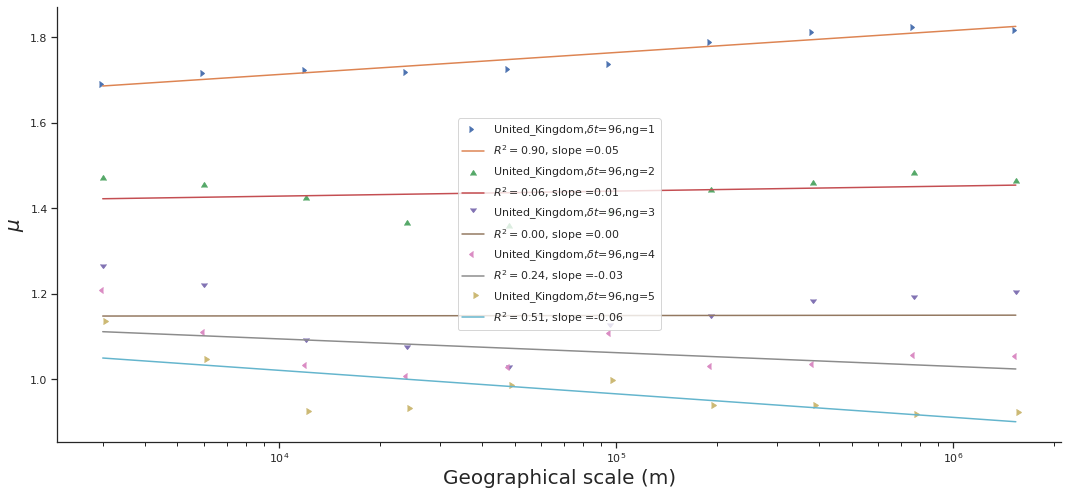

In [100]:
fig,ax = plt.subplots(figsize=(18,8))
NGRAMS = np.arange(1,6,1)
markers = np.arange(4,10,1)
for ngram in NGRAMS:
    df = plot_paramet('spatial','mu','United_Kingdom',ngram,96,ax,markers[ngram])
    resid = regression_param(df,ax)
    ax.set_xscale('log')
    ax.legend()
    sns.despine()

In [109]:
def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

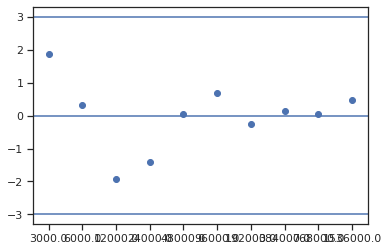

In [111]:
plt.scatter(np.array(df.columns),standardize(resid))
plt.axhline(resid.mean())
plt.axhline(3); plt.axhline(-3)

In [12]:
import statsmodels.api as sm

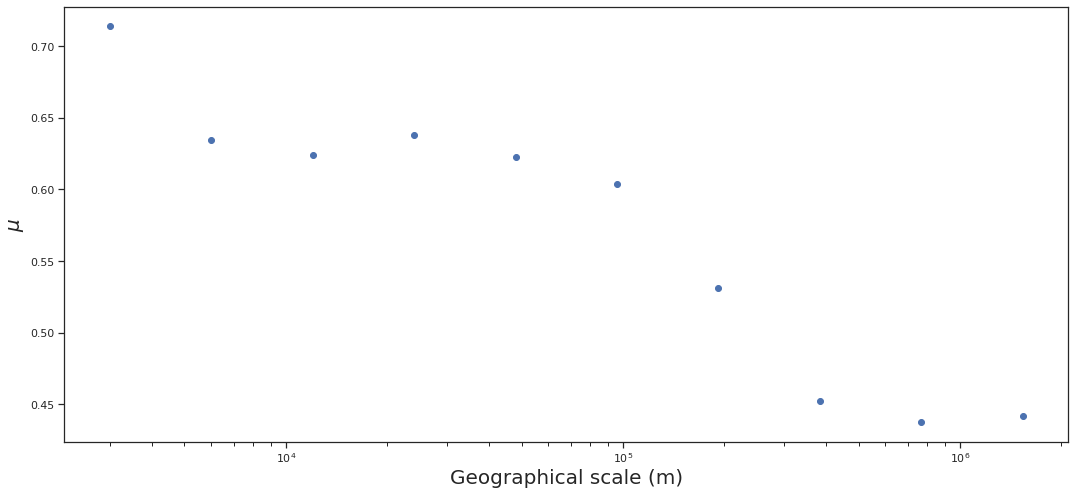

In [78]:
fig1,ax1 = plt.subplots(figsize=(18,8))
ngram=5
df = plot_paramet('spatial','mu','United_Kingdom',ngram,3,ax1)
ax1.set_xscale('log')

In [88]:
y = df.iloc[4,:]
X = np.log10(np.array(df.columns,float))
X = sm.add_constant(X)

In [89]:
linear_reg = sm.OLS(y,X)
fittedmod = linear_reg.fit()

In [90]:
fittedmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      5   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     66.68
Date:                Fri, 29 May 2020   Prob (F-statistic):           3.77e-05
Time:                        01:24:38   Log-Likelihood:                 20.789
No. Observations:                  10   AIC:                            -37.58
Df Residuals:                       8   BIC:                            -36.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0581      0.061     17.420      0.000       0.918       1.198
x1            -0.1010      0.012     -8.166      0.000      -0.130      -0.073
==============================================================================
Omnibus:                        0.978   Durbin-Watson:                   1.177
Prob(Omnibus):                  0.613   Jarque-Bera (JB):                0.625
Skew:                           0.023   Prob(JB):                        0.732
Kurtosis:                       1.776   Cond. No.                         29.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""